In [1]:
# Setup display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","Plots","JLD2","FileIO","ImageMagick"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Base.Iterators: flatten
using FileIO; 
using ImageMagick; 
using MAT; 
using Statistics: mean
using Plots;
using Knet: Knet, conv4, pool, mat, KnetArray, nll, zeroone, Param,progress, sgd,dropout, relu,
Data,sigm, xavier,gpu,softmax
import Knet:param,param0
using Images;
using JLD2,Random

In [2]:
include("minibatch_updated.jl") #Original Knet minibacth is changes because there are two inputs in the 
#model. New minibatch iterates over two inputs.

In [3]:
atype()=(gpu() >= 0 ? KnetArray{Float32} : Array{Float32})
param(d...; init=xavier, atype=atype())=Param(atype(init(d...)))
param0(d...; atype=atype())=param(d...; init=zeros, atype=atype)

param0 (generic function with 1 method)

In [2]:
function image_data(img,image_size)
    global _imgcache
    if !@isdefined(_imgcache); _imgcache = Dict(); end
        a0=img
        a0=Gray.(a0)
        new_size = ntuple(i->div(size(a0,i)*image_size,minimum(size(a0))),2)
        a1 = Images.imresize(a0, new_size)
        i1 = div(size(a1,1)-image_size,2)
        j1 = div(size(a1,2)-image_size,2)
        b1 = a1[i1+1:i1+image_size,j1+1:j1+image_size]
        b1 = convert(Array{FixedPointNumbers.Normed{UInt8,8},2}, b1)
       # d1 = convert(atype(), b1)
        e1 = reshape(b1[:,:,1], (image_size,image_size,1,1))
        f1 = (255 * e1)
        #g1 = permutedims(f1, [2,1,3,4])
    return f1
end

image_data (generic function with 1 method)

In [3]:
function read_data(data_path,image_size)
i=1
first_r=true
y=[]
x=0
folders=readdir(data_path)
for class in folders
    println("Class number ",i," ",class)
    directory=string(data_path,"/",class)
    for img in readdir(directory)
            
        arr_img=load(string(directory,"/",img))
            
        arr_img=image_data(arr_img,image_size)   
        label=zeros(size(folders))
        label[i]=1
        if first_r==false
            x=cat(x,arr_img,dims=4)
        else
            x=cat(arr_img,dims=4)
        end
        push!(y,i)
        first_r=false
    end
    i+=1
    end
println(size(y))
println(size(x))
return x,y;
end

read_data (generic function with 1 method)

In [6]:
struct Chain
    layers
    Chain(layers...)=new(layers)
end
(c::Chain)(x) = (for layer in c.layers; x=layer(x) end;x)
(c::Chain)(x,y)=nll(c(x),y) #loss
(c::Chain)(d::Data)=mean(c(x,y) for (x,y) in d) #batch için mean loss hesapla

In [207]:
mutable struct Ensemble2 model1;model2;alpha; #an ensemble model that takes two Chains
    Ensemble2(model1,model2,alpha)=new(model1,model2,alpha)
end
(e::Ensemble2)(x1,x2)=e.model1(x1)*e.alpha+e.model2(x2)*(10-e.alpha)#for some reason alpha needs to be integer
#instead of using 0-1 scale use 0-10
#(e::Ensemble)(x1,x2)=e.model1(x1)+e.model2(x2)
(e::Ensemble2)(x1,x2,y)=nll(e(x1,x2),y) #loss
(e::Ensemble2)(d::Data3d)=mean(e(x1,x2,y) for (x1,x2,y) in d)

In [8]:
struct Conv;w;b;pad;func;end; #eğitilecek conv layerlar
Conv(m::Int,n::Int,k_in::Int,k_out::Int,pad,func)=Conv(param(m,n,k_in,k_out),param0(1,1,k_out,1),pad,func)
(c::Conv)(x)=c.func.(conv4(c.w,x,padding=c.pad).+c.b)

In [9]:
struct Conv_vgg; w;b;func; #vgg'den weightleri alan conv
    Conv_vgg(w,b)=new(Param(w),Param(b),relu)
    Conv_vgg(w,b,func)=new(Param(w),Param(b),func)
    end;
(c::Conv_vgg)(x)=c.func.(conv4(c.w,x,padding=1,mode=1).+c.b)
#(c::Conv)(x)=conv4(c.w,x,padding=1,mode=1).+c.b

In [10]:
struct Res_Conv; w;b;func;end;
Res_Conv(m::Int,n::Int,k_in::Int,k_out::Int,func)=Res_Conv(param(m,n,k_in,k_out),param0(1,1,k_out,1),func)# m,n windows size, k_in input
(c::Res_Conv)(x)=cat(mat(x),mat(c.func.(pool(conv4(c.w,x,padding=0).+c.b))),dims=1) #k_out output size (number of filters)

In [11]:
struct Pool end
(p::Pool)(x)=pool(x)

In [12]:
struct Fully2; w;b;func;pdrop;end;
Fully2(m::Int,n::Int,func,pdrop)=Fully2(param(n,m),param0(n),func,pdrop)
(ful::Fully2)(x)=ful.func.(ful.w*dropout(x,ful.pdrop).+ful.b)

In [13]:
struct Dense; w;b;func;pdrop;
    Dense(w,b)=new(Param(w),Param(b),relu)
    Dense(w,b,func)=new(Param(w),Param(b),func) #dosyadan okunan weigtler
    Dense(x::Int,y::Int,func,pdrop)=new(param(y,x),param0(y),func,pdrop) #random atanan weigthler
    end;
function (den::Dense)(x) 
    matrix_multip=den.w*dropout(mat(x),den.pdrop).+den.b
    if den.func==relu
        return den.func.(matrix_multip)
    else
        return den.func(matrix_multip)
    end
end 

In [5]:
train_x1,train_y1=read_data("augment_data_50_copy_another_subject/processed/Train",72); #load images

Class number 1 Angry
Class number 2 Disgusted
Class number 3 Fear
Class number 4 Happy
Class number 5 Sad
Class number 6 Suprised
(8200,)
(72, 72, 1, 8200)


In [6]:
save("train_x1_another_subject.jld2","data",train_x1)

In [8]:
save("train_y1_another_subject.jld2","data",train_y1)

In [21]:
train_x2,train_y2=read_data("ege_data/augmetn_x50_one_subject/lbp/Train",72);

Class number 1 Angry
Class number 2 Disgusted
Class number 3 Fear
Class number 4 Happy
Class number 5 Sad
Class number 6 Suprised
(8150,)
(72, 72, 1, 8150)


In [22]:
save("train_x2.jld2","data",train_x2)

In [23]:
test_x1,test_y1=read_data("ege_data/augmetn_x50_one_subject/processed/Test",72);
test_x2,test_y2=read_data("ege_data/augmetn_x50_one_subject/lbp/Test",72);

Class number 1 Angry
Class number 2 Disgusted
Class number 3 Fear
Class number 4 Happy
Class number 5 Sad
Class number 6 Suprised
(1000,)
(72, 72, 1, 1000)
Class number 1 Angry
Class number 2 Disgusted
Class number 3 Fear
Class number 4 Happy
Class number 5 Sad
Class number 6 Suprised
(1000,)
(72, 72, 1, 1000)


In [24]:
save("test_x1.jld2","data",test_x1)
save("test_x2.jld2","data",test_x2)
save("test_y1.jld2","data",test_y1)

In [17]:
train_x1=load("train_x1.jld2")["data"];
train_x2=load("train_x2.jld2")["data"];
train_y1=load("train_y1.jld2")["data"];

test_x1=load("test_x1.jld2")["data"];
test_x2=load("test_x2.jld2")["data"];
test_y1=load("test_y1.jld2")["data"];

In [18]:
println(summary(train_x1))
println(summary(train_x2))
println(summary(train_y1))
println(summary(test_x1))
println(summary(test_x2))
println(summary(test_y1))

72×72×1×8150 Array{Float32,4}
72×72×1×8150 Array{Float32,4}
8150-element Array{Any,1}
72×72×1×1000 Array{Float32,4}
72×72×1×1000 Array{Float32,4}
1000-element Array{Any,1}


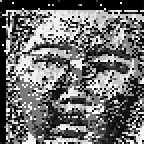

In [20]:
colorview(Gray,train_x2[:,:,1,268]./255)

In [26]:
train_data=minibatch_3d(train_x1,train_x2,train_y1,50,shuffle=true,x1type=KnetArray{Float32},x2type=KnetArray{Float32},ytype=Array{Int32});
test_data=minibatch_3d(test_x1,test_x2,test_y1,50,shuffle=true,x1type=KnetArray{Float32},x2type=KnetArray{Float32},ytype=Array{Int32});

In [229]:
weight_dict=matread("imagenet-vgg-no-fc+conv5-16.mat") #load VGG weigts from matlab file
layers=weight_dict["layers"]
w_arr=[]
for layer in layers
    if occursin("conv",layer["name"])
        w=layer["weights"]
        push!(w_arr,w[1])
        b=reshape(w[2], (1,1,length(w[2]),1))
        push!(w_arr,b)
        elseif occursin("fc",layer["name"])
            w=layer["weights"]
            w[1] = transpose(mat(w[1]))
            push!(w_arr,w[1])
            push!(w_arr,w[2])
        end
end

In [230]:
w_gray=w_arr[1][:,:,1,:]+w_arr[1][:,:,2,:]+w_arr[1][:,:,3,:]; #the input of network is grayscale but
w_gray=reshape(w_gray,(3,3,1,64)); #VGG input is RGB so the 3 channel's weigths are added
w_gray=convert(atype(),w_gray)
summary(w_gray)
for i in 1:size(w_arr,1)
    w_arr[i]=convert(atype(),w_arr[i])
end

In [239]:
Knet.seed!(1); #VGG model
Vgg_model=Chain(Conv_vgg(w_gray,w_arr[2]),Conv_vgg(w_arr[3],w_arr[4]),Pool(),  
    Conv_vgg(w_arr[5],w_arr[6]),Conv_vgg(w_arr[7],w_arr[8]),Pool(),              
    Conv_vgg(w_arr[9],w_arr[10]),Conv_vgg(w_arr[11],w_arr[12]),Conv_vgg(w_arr[13],w_arr[14]),Pool(),       
    Conv_vgg(w_arr[15],w_arr[16]),Conv_vgg(w_arr[17],w_arr[18]),Conv_vgg(w_arr[19],w_arr[20]),Pool(),
    Conv(7,7,512,256,3,relu),Conv(3,3,256,256,1,relu),Conv(3,3,256,512,1,relu),Pool(),
    Dense(512*2*2,500,relu,0.7),
    Dense(500,100,relu,0.8),Dense(100,6,identity,false));

In [246]:
Knet.seed!(2); #Shallow part
shallow=Chain(Conv(7,7,1,64,3,relu),Pool(),Res_Conv(3,3,64,256,relu),Fully2(17*17*256+36*36*64,500,relu,0.7),
Fully2(500,100,relu,0.8),Fully2(100,6,identity,false));

In [34]:
function ensemble_accuracy(y,a::AbstractArray{<:Integer}; dims=1, average=true) 
    indices = Knet.findindices(y,a,dims=dims) 
    ycpu = convert(Array,y)
    (maxval,maxind) = findmax(ycpu,dims=dims)
    maxind = LinearIndices(ycpu)[maxind]
    correct = (vec(maxind) .== indices)
    average ? mean(correct) : sum(correct)
end

ensemble_accuracy (generic function with 1 method)

In [35]:
function ensemble_accuracy(model, data; dims=1, average=true, o...)#change the zeroone acc
    sum = cnt = 0                                                  #so that it can work with 2 inputs
    for (x1,x2,y) in data
        sum += ensemble_accuracy(model(x1,x2; o...), y; dims=dims, average=false)
        cnt += length(y)
    end
    average ? sum / cnt : sum
end

ensemble_accuracy (generic function with 2 methods)

In [36]:
# For running experiments
function trainresults2(model,dtrn,dtst,ep,optimizer,learning_r)
    train_iter(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)
                
        r = ((model(dtrn), model(dtst), ensemble_accuracy(model,dtrn), ensemble_accuracy(model,dtst))
             for x in train_iter(length(dtrn), progress(optimizer(model,repeat(dtrn,ep),lr=learning_r))))
        r = reshape(collect(Float32,flatten(r)),(4,:))          
    return r
end

trainresults2 (generic function with 1 method)

In [247]:
ensemble=Ensemble2(Vgg_model,shallow,7);

In [59]:
results=trainresults2(ensemble,train_data,test_data,50,Knet.adam,0.0001);

1.36e-03  100.00%┣██████████████▉┫ 8150/8150 [01:33:20/01:33:20, 1.46i/s]


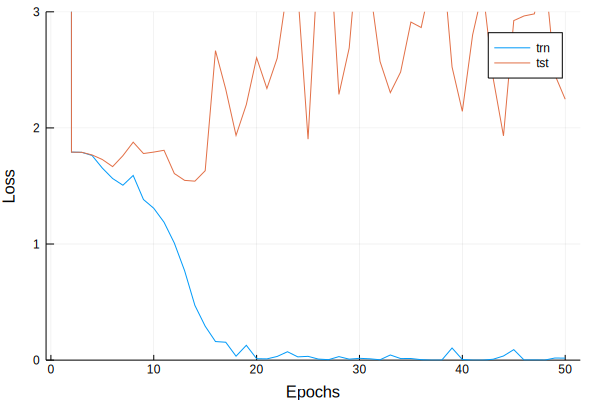

In [60]:
plot([results[1,:], results[2,:]],ylim=(0,3),
     labels=[:trn :tst],xlabel="Epochs",ylabel="Loss")

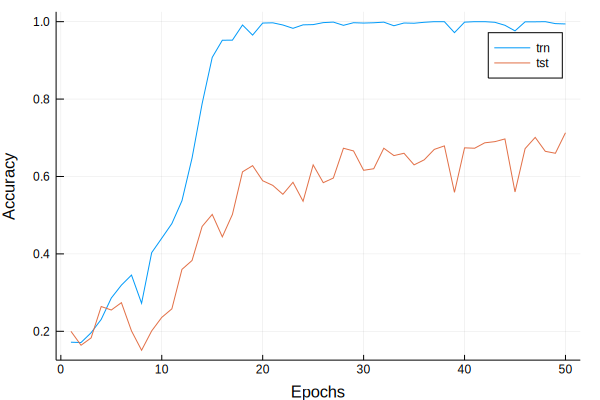

In [61]:
plot([results[3,:], results[4,:]],
     labels=[:trn :tst],xlabel="Epochs",ylabel="Accuracy")

In [235]:
path_normal="ege_data/augmetn_x50_one_subject/processed/Test/Happy/KA.HA4.32_38.tiff"
path_lbp="ege_data/augmetn_x50_one_subject/lbp/Test/Happy/KA.HA4.32_38.tiff"
normal_img=image_data(load(path_normal),72);
lbp_img=image_data(load(path_lbp),72); #SA->Sad
normal_img=convert(KnetArray{Float32},normal_img);
lbp_img=convert(KnetArray{Float32},lbp_img);

In [236]:
pred=softmax(ensemble(normal_img,lbp_img)) #fifth category is sad

6×1 KnetArray{Float32,2}:
 2.0739457e-27
 6.7044555e-30
 1.9724463e-12
 0.0012566214 
 0.99874324   
 1.7723669e-7 

In [149]:
class_image_numbers=[]
count=1
number_img=1
for i in 1:6
    for j in count:size(test_y1,1)
        if test_y1[j]==i
        count+=1
        number_img+=1
        end
    end
    push!(class_image_numbers,number_img-1)
    number_img=1
end
println(class_image_numbers)
ranges=class_image_numbers
for i in 2:size(ranges,1)
    ranges[i]+=ranges[i-1]
end
println(ranges)

Any[150, 150, 200, 200, 150, 150]
Any[150, 300, 500, 700, 850, 1000]


In [248]:
first=0
second=ranges[1]
for i in 2:7   
    batch_size=second-first
    println(batch_size)
    range=first+1:second
    println(range)
    test_category_set=test_data=minibatch_3d(test_x1[:,:,:,range],test_x2[:,:,:,range],test_y1[range],batch_size,shuffle=true,x1type=KnetArray{Float32},x2type=KnetArray{Float32},ytype=Array{Int32});
    println(ensemble_accuracy(ensemble,test_category_set)) #find class based accuracy
    first=ranges[i-1]
    second=ranges[i]
end
#The error below is not important because there are only 6 classes. So it gets class accuracies for
#all 6 classes

150
1:150
0.0
150
151:300
0.0
200
301:500
0.0
200
501:700
0.055
150
701:850
0.1
150
851:1000
0.8133333333333334


BoundsError: BoundsError: attempt to access 6-element Array{Any,1} at index [7]